# **1. Perkenalan Dataset**



### Data Overview

**Nama Dataset:** Kredivo Dataset
**Sumber:** [Kaggle – Kredivo Dataset](https://www.kaggle.com/datasets/nuricahyono/kredivo)
**Penyedia:** pengguna `nuricahyono`

**Deskripsi Umum:**
Dataset ini berisi informasi mengenai ulasan-ulasan dari aplikasi pinjam dana yaitu kredivo. Dengan dataset ini saya akan membuat suatu analisa sentimen pengguna terhadap aplikasi melalui ulasan mereka
**Jumlah Data:**

* Total baris (record): ± 100.000 baris
* Total kolom (fitur): 4 kolom

**Fitur Utama (Contoh):**

1. **userName** – nama pengguna
2. **score** – rating yang diberikan
3. **at** – tanggal pengunggahan ulasan
4. **content** – Ulasan Pengguna



**Catatan:**
Dataset ini dapat memerlukan pra-pemrosesan seperti penanganan missing values, encoding untuk fitur kategori, dan normalisasi data numerik sebelum digunakan dalam analisis atau pemodelan.


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [ ]:
!pip install sastrawi
!pip install pyswarms
!pip install skopt

import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import requests
import csv
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [ ]:
data = ('Kredivo.csv')
df = pd.read_csv(data)

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [ ]:
df.head()

,userName,score,at,content
0,Pengguna Google,5,2024-09-08 02:58:28,Kredivo sangan membatu thebest bnget. Tapi ada...
1,Pengguna Google,5,2024-09-08 02:58:08,Membantu...
2,Pengguna Google,1,2024-09-08 02:56:44,"Perhatian ,Tolong para pengguna dan yg punya a..."
3,Pengguna Google,5,2024-09-08 02:55:35,Kren
4,Pengguna Google,5,2024-09-08 02:54:51,aplikasi yang sangat membantu kebutuhan dengan...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userName  100000 non-null  object
 1   score     100000 non-null  int64 
 2   at        100000 non-null  object
 3   content   100000 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


In [ ]:
print("Jumlah nilai null:\n", df['content'].isnull().sum())

Jumlah nilai null:
 0


Jenis objek data: <class 'pandas.core.frame.DataFrame'>
count    100000.000000
mean          7.326890
std          10.149726
min           1.000000
25%           2.000000
50%           4.000000
75%           9.000000
max          99.000000
Name: text_word_count, dtype: float64


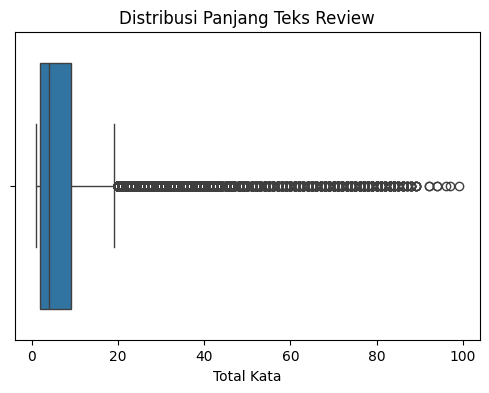

In [ ]:
print("Jenis objek data:", type(df))

# Menghitung jumlah kata pada setiap teks
df["text_word_count"] = df["content"].astype(str).map(lambda teks: len(teks.split()))

# Menampilkan ringkasan statistik jumlah kata
print(df["text_word_count"].describe())

# Visualisasi distribusi jumlah kata menggunakan boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["text_word_count"])
plt.title("Distribusi Panjang Teks Review")
plt.xlabel("Total Kata")
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [ ]:
# Load slangwords dari file lokal
slang_df = pd.read_csv("/content/indonesian-slangwords.csv")
slang_dict = dict(zip(slang_df['@'], slang_df['di']))

In [ ]:
def cleaningText(text):
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'RT\s+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    return text.strip()


In [ ]:
def casefoldingText(text):
    return text.lower()
def fix_slangwords(text):
    words = text.split()
    return ' '.join([slang_dict.get(word, word) for word in words])
def tokenizingText(text):
    return word_tokenize(text)
def filteringText(tokens):
    stop_id = set(stopwords.words('indonesian'))
    stop_en = set(stopwords.words('english'))

    custom_stopwords = {
        'iya','yaa','gak','nya','na','sih','ku',
        'di','ga','ya','loh','kah','woi','woy'
    }

    stopwords_all = stop_id | stop_en | custom_stopwords

    return [word for word in tokens if word not in stopwords_all]
def toSentence(tokens):
    return ' '.join(tokens)

In [ ]:
df['text_clean'] = df['content'].apply(cleaningText)
df['text_clean'] = df['text_clean'].apply(casefoldingText)
df['text_clean'] = df['text_clean'].apply(fix_slangwords)
df['tokens'] = df['text_clean'].apply(tokenizingText)
df['tokens'] = df['tokens'].apply(filteringText)
df['text_final'] = df['tokens'].apply(toSentence)


In [ ]:

df.head()

,userName,score,at,content,text_word_count
0,Pengguna Google,5,2024-09-08 02:58:28,Kredivo sangan membatu thebest bnget. Tapi ada...,45
1,Pengguna Google,5,2024-09-08 02:58:08,Membantu...,1
2,Pengguna Google,1,2024-09-08 02:56:44,"Perhatian ,Tolong para pengguna dan yg punya a...",49
3,Pengguna Google,5,2024-09-08 02:55:35,Kren,1
4,Pengguna Google,5,2024-09-08 02:54:51,aplikasi yang sangat membantu kebutuhan dengan...,10


In [ ]:
def get_sentiment(score):
    if score <= 3:
        return 'negatif'
    else:
        return 'positif'


df['sentiment_category'] = df['score'].apply(get_sentiment)

print(df['sentiment_category'].value_counts())

sentiment_category
positif    84601
negatif    15399
Name: count, dtype: int64


In [ ]:
# Menampilkan distribusi data sebelum penyeimbangan
print("Distribusi data awal:")
print(df['sentiment_category'].value_counts())

# Menentukan jumlah minimum dari setiap kelas
target_size = df['sentiment_category'].value_counts().min()
print(f"\nJumlah sampel per kelas yang digunakan: {target_size}")

# Melakukan undersampling agar setiap kelas memiliki jumlah data yang sama
df_equalized = (
    df.groupby('sentiment_category', group_keys=False)
      .apply(lambda data: data.sample(n=target_size, random_state=42))
)

# Menampilkan distribusi data setelah proses undersampling
print("\nDistribusi data setelah undersampling:")
print(df_equalized['sentiment_category'].value_counts())

Distribusi data awal:
sentiment_category
positif    84601
negatif    15399
Name: count, dtype: int64

Jumlah sampel per kelas yang digunakan: 15399

Distribusi data setelah undersampling:
sentiment_category
negatif    15399
positif    15399
Name: count, dtype: int64


/tmp/ipython-input-3332928689.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda data: data.sample(n=target_size, random_state=42))


In [ ]:
df_equalized['sentiment_category'].value_counts()

,count
sentiment_category,
negatif,15399
positif,15399


In [ ]:
df.head()

,userName,score,at,content,text_word_count,sentiment_category,text_clean,tokens,text_final
0,Pengguna Google,5,2024-09-08 02:58:28,Kredivo sangan membatu thebest bnget. Tapi ada...,45,positif,kredivo sangan membatu thebest banget tapi ada...,"[kredivo, sangan, membatu, thebest, banget, ke...",kredivo sangan membatu thebest banget kesalaha...
1,Pengguna Google,5,2024-09-08 02:58:08,Membantu...,1,positif,membantu,[membantu],membantu
2,Pengguna Google,1,2024-09-08 02:56:44,"Perhatian ,Tolong para pengguna dan yg punya a...",49,negatif,perhatian tolong para pengguna dan yang punya ...,"[perhatian, tolong, pengguna, aplikasitolong, ...",perhatian tolong pengguna aplikasitolong jelas...
3,Pengguna Google,5,2024-09-08 02:55:35,Kren,1,positif,kren,[kren],kren
4,Pengguna Google,5,2024-09-08 02:54:51,aplikasi yang sangat membantu kebutuhan dengan...,10,positif,aplikasi yang sangat membantu kebutuhan dengan...,"[aplikasi, membantu, kebutuhan, bunga, terjang...",aplikasi membantu kebutuhan bunga terjangkau


In [ ]:
df.to_csv('preprocessed_kredivo.csv', index=False)

print('dataset berhasil disimpan')

dataset berhasil disimpan
